<a href="https://colab.research.google.com/github/Vridhi-Wadhawan/deep-learning-models-in-practice/blob/main/04_image_classification_transfer_learning_resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification Using Transfer Learning (ResNet-50)


## Overview

This project applies transfer learning to a multi-class image classification problem involving food brand logos.

The goal is to evaluate how pretrained convolutional networks adapt to domain-specific visual patterns under class imbalance and limited data.

- **Problem**: Multi-class logo classification under class imbalance
- **Data**: Food brand logos (Burger King, KFC, McDonald’s, Starbucks, Subway, Other)
- **Model**: ResNet-50 pretrained on ImageNet
- **Approach**:
  - Frozen backbone + custom classifier
  - Staged training with progressive data exposure
  - Class-balanced loss and weighted sampling
  - Fine-tuning higher CNN layers
- **Key Challenge**: Minority class generalisation



## Environment & Dependencies

In [ ]:
# Importing Libraries
import os, random, zipfile, shutil
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
from tqdm import tqdm

import kagglehub

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, random_split

import torchvision
from torchvision import transforms, datasets, models

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.metrics import precision_recall_fscore_support

## Configuration

Key training and data parameters were centralised to ensure reproducibility and controlled experimentation.

- Image resolution fixed at **224×224** to match ImageNet pretraining
- Moderate batch size (**32**) for stable optimisation
- Low learning rate suitable for transfer learning
- Validation split used for early stopping and model selection

In [ ]:
# Configuration
CONFIG = {
    "dataset_ref": "kmkarakaya/logos-bk-kfc-mcdonald-starbucks-subway-none",
    "raw_dir": "logos_raw",
    "data_dir": "logos_data",
    "batch_size": 32,
    "img_size": 224,
    "lr": 1e-3,
    "n_epochs": 8,
    "seed": 38,
    "val_split": 0.2,
    "num_workers": 2,
    "checkpoint_path": "best_resnet50.pth",
    "use_weighted_sampler": True,
    "unfreeze_layer4_on_finetune": True}

## Dataset

The dataset consists of food brand logos across six classes:

- Burger King
- KFC
- McDonald’s
- Starbucks
- Subway
- Other

Images are provided in predefined train and test splits. The dataset exhibits **class imbalance**, with dominant representation of the *Other* class.


In [ ]:
# Dataset Download
def load_logo_dataset(ref, dest="logos_raw"):
    path = kagglehub.dataset_download(ref)
    if os.path.isdir(path):
        return path
    ext = Path(path).suffix.lower()
    os.makedirs(dest, exist_ok=True)
    if ext == ".zip":
        with zipfile.ZipFile(path, "r") as zf:
            zf.extractall(dest)
        return dest
    else:
        shutil.unpack_archive(path, dest)
        return dest

In [ ]:
raw_root = load_logo_dataset(CONFIG["dataset_ref"], CONFIG["raw_dir"])
print("Raw dataset root:", raw_root)

Using Colab cache for faster access to the 'logos-bk-kfc-mcdonald-starbucks-subway-none' dataset.
Raw dataset root: /kaggle/input/logos-bk-kfc-mcdonald-starbucks-subway-none


## Reproducibility

In [ ]:
# Reproducibility
def set_seed(seed=CONFIG["seed"]):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
set_seed(CONFIG["seed"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


To ensure that the results are consistent across multiple runs, random seeds were fixed. Additionally, CUDA backends were set to deterministic mode to avoid variations due to GPU optimizations. Making the training process reproducible.  


##  Data Preparation

In [ ]:
#  Data Preparation
train_dir = os.path.join(raw_root, "logos3/train")
test_dir  = os.path.join(raw_root, "logos3/test")

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(CONFIG["img_size"]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),              # more rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # brightness/contrast
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2)), # scaling
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])])

In [ ]:
transform_eval = transforms.Compose([
    transforms.Resize((CONFIG["img_size"], CONFIG["img_size"])),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])])

In [ ]:
# Loading train + test datasets
train_dataset_full = datasets.ImageFolder(root=train_dir, transform=transform_train)
test_dataset_full  = datasets.ImageFolder(root=test_dir,  transform=transform_eval)

In [ ]:
class_names = train_dataset_full.classes
print("Classes:", class_names)

Classes: ['Burger King', 'KFC', 'McDonalds', 'Other', 'Starbucks', 'Subway']


The dataset was organized in train and test folders.  
- Training images were used to train the model.  
- Test images were used to evaluate final performance.  

Data augmentation was applied to the training set to improve generalization. The transformations included random resizing and cropping, horizontal flipping, small rotations and affine transformations and color jitter for brightness, contrast, and saturation.

For both training and evaluation sets, normalization was applied using ImageNet’s mean and standard deviation, ensuring compatibility with the pre-trained models.  


## Splitting Data

## Staged Training Strategy

To simulate incremental data availability and reduce early overfitting, training was conducted in stages:

1. Train on subset T1 → evaluate on T2  
2. Extend training on T2 → evaluate on T3  
3. Extend training on T3 → evaluate on validation set  

This approach allowed controlled capacity growth before full fine-tuning.


In [ ]:
#  Creating Validation Split
val_split = CONFIG["val_split"]
n_total = len(train_dataset_full)
n_val = int(val_split * n_total)
n_train = n_total - n_val

In [ ]:
train_dataset, val_dataset = random_split(
    train_dataset_full,
    [n_train, n_val],
    generator=torch.Generator().manual_seed(CONFIG["seed"]))

In [ ]:
# Compute class counts for WeightedRandomSampler
targets = [train_dataset_full[i][1] for i in train_dataset.indices] if isinstance(train_dataset, torch.utils.data.Subset) else [y for _, y in train_dataset]

In [ ]:
class_counts = np.bincount(targets)
class_weights = 1. / class_counts
sample_weights = [class_weights[t] for t in targets]

In [ ]:
sampler = torch.utils.data.WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

In [ ]:
print(f"Final sizes: \nTrain: {len(train_dataset)} \nVal: {len(val_dataset)} \nTest: {len(test_dataset_full)}")

Final sizes: 
Train: 1391 
Val: 347 
Test: 560


In [ ]:
# Create T1/T2/T3 Folds From Train
fold_size = len(train_dataset) // 3
indices = list(range(len(train_dataset)))
random.shuffle(indices)

In [ ]:
T1_idx = indices[:fold_size]
T2_idx = indices[fold_size:2*fold_size]
T3_idx = indices[2*fold_size:]

In [ ]:
train_T1 = Subset(train_dataset, T1_idx)
train_T2 = Subset(train_dataset, T2_idx)
train_T3 = Subset(train_dataset, T3_idx)

##  DataLoaders

In [ ]:
# Train loader with sampler (used only in fine-tuning)
loader_train = DataLoader(
    train_dataset,
    batch_size=CONFIG["batch_size"],
    sampler=sampler,   # balances minority classes
    num_workers=CONFIG["num_workers"])

In [ ]:
# For staged training, keep T1/T2/T3 loaders simple
loader_T1 = DataLoader(train_T1, batch_size=CONFIG["batch_size"], shuffle=True, num_workers=CONFIG["num_workers"])
loader_T2 = DataLoader(train_T2, batch_size=CONFIG["batch_size"], shuffle=True, num_workers=CONFIG["num_workers"])
loader_T3 = DataLoader(train_T3, batch_size=CONFIG["batch_size"], shuffle=True, num_workers=CONFIG["num_workers"])

In [ ]:
# Validation & Test loaders
loader_val = DataLoader(val_dataset, batch_size=CONFIG["batch_size"], shuffle=False, num_workers=CONFIG["num_workers"])
loader_test = DataLoader(test_dataset_full, batch_size=CONFIG["batch_size"], shuffle=False, num_workers=CONFIG["num_workers"])

### Model Setup

The base model used was ResNet-50 which is pretrained on ImageNet for transfer learning. We replaced the last fully connected layer to handle the six specific logo classes. All backbone layers are frozen initially and only the new FC layer was trained. The Adam optimizer and Cross-Entropy Loss with class weights were used to manage the training process and address class imbalance.


In [ ]:
# Model Setup
def get_resnet50_model(num_classes, finetune=False):
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False
    if finetune and CONFIG["unfreeze_layer4_on_finetune"]:
        for param in model.layer4.parameters():
            param.requires_grad = True
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model.to(device)

In [ ]:
# Training
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return running_loss / total, correct / total

In [ ]:
# Evaluation
def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_labels, all_preds = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    return running_loss / total, correct / total, all_labels, all_preds

### Training and Evaluation On Training Dataset

In [ ]:
# Class-balanced loss
targets_all = [train_dataset_full[i][1] for i in train_dataset_full.indices] if isinstance(train_dataset_full, torch.utils.data.Subset) else [y for _, y in train_dataset_full]
class_counts = np.bincount(targets_all)
weights = torch.tensor(1.0 / class_counts, dtype=torch.float32).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss(weight=weights)
model = get_resnet50_model(len(class_names))
optimizer = optim.Adam(model.parameters(), lr=CONFIG["lr"])

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 192MB/s]


#### Train on T1, Evaluation on T2

In [ ]:
print("\nTrain on T1, Evaluation on T2")
for epoch in range(2):
    train_loss, train_acc = train_one_epoch(model, loader_T1, criterion, optimizer)
    val_loss, val_acc, _, _ = evaluate(model, loader_T2, criterion)
    print(f"Epoch {epoch+1}/2 -> Train Loss: {train_loss:.4f} | T2 Loss: {val_loss:.4f} | T2 Acc: {val_acc:.4f}")


Train on T1, Evaluation on T2
Epoch 1/2 -> Train Loss: 1.6752 | T2 Loss: 1.6830 | T2 Acc: 0.6069
Epoch 2/2 -> Train Loss: 1.4181 | T2 Loss: 1.4924 | T2 Acc: 0.6760


The model was initially trained for 2 epochs on the T1 subset of the data and evaluated on the T2 subset.

As seen in the results, the model’s accuracy on the T2 subset improved from 60.69% to 67.60% over the two epochs, indicating that the model began to learn and generalize from the T1 data.

In [ ]:
# Classification Report
_, _, y_true, y_pred = evaluate(model, loader_T2, criterion)
print("\nClassification Report (Train on T1, Evaluation on T2):")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report (Train on T1, Evaluation on T2):
              precision    recall  f1-score   support

 Burger King       0.66      0.57      0.61        72
         KFC       0.00      0.00      0.00        28
   McDonalds       0.74      0.62      0.68        56
       Other       0.87      0.85      0.86       208
   Starbucks       0.42      0.81      0.56        58
      Subway       0.49      0.49      0.49        41

    accuracy                           0.69       463
   macro avg       0.53      0.56      0.53       463
weighted avg       0.68      0.69      0.68       463



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


The overall accuracy on the T2 set was 67%. The model performed best on the Other class, with an F1-score of 0.86, showing high precision and recall.
KFC had the worst performance, with a precision, recall, and f1-score of 0.00, meaning it was never correctly predicted. This could be due to a severe class imbalance or a lack of distinct features for the model to learn.
McDonalds and Starbucks also showed low precision and recall, suggesting the model struggled with these specific classes.
Burger King and Subway had moderate performance, with F1-scores around 0.61 and 0.49 respectively.

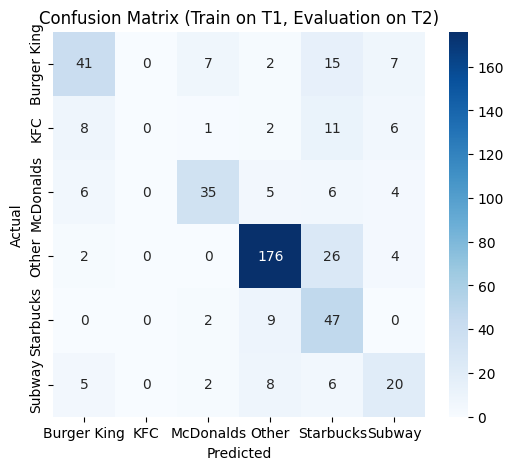

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix (Train on T1, Evaluation on T2)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

The confusion matrix visually confirms the classification report's findings, highlighting how the model frequently confused certain classes. For example, a few of Starbucks class were often misclassified as Other.

At this stage, the model shows signs of class imbalance, where minority classes are ignored in favor of dominant ones.

#### Train on T2, Evaluation on T3

After training on the T1 set, the model was further trained on the T2 subset for 2 epochs and evaluated on the T3 subset. This step was crucial to incrementally improve the model's performance by exposing it to more data.

In [ ]:
print("\nTrain on T2, Evaluation on T3")
for epoch in range(2):
    train_loss, train_acc = train_one_epoch(model, loader_T2, criterion, optimizer)
    val_loss, val_acc, _, _ = evaluate(model, loader_T3, criterion)
    print(f"Epoch {epoch+1}/2 -> Train Loss: {train_loss:.4f} | T3 Loss: {val_loss:.4f} | T3 Acc: {val_acc:.4f}")


Train on T2, Evaluation on T3
Epoch 1/2 -> Train Loss: 1.4649 | T3 Loss: 1.3160 | T3 Acc: 0.6323
Epoch 2/2 -> Train Loss: 1.2917 | T3 Loss: 1.2228 | T3 Acc: 0.6860


The accuracy on the T3 subset improved from 63.23% to 68.60%, showing the model continued to learn effectively with the additional training data.

In [ ]:
# Classification Report
_, _, y_true, y_pred = evaluate(model, loader_T3, criterion)
print("\nClassification Report (Train on T2, Evaluation on T3):")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report (Train on T2, Evaluation on T3):
              precision    recall  f1-score   support

 Burger King       1.00      0.31      0.48        86
         KFC       0.17      0.76      0.27        21
   McDonalds       0.57      0.72      0.64        43
       Other       0.97      0.83      0.89       222
   Starbucks       0.86      0.57      0.69        56
      Subway       0.48      0.78      0.59        37

    accuracy                           0.69       465
   macro avg       0.67      0.66      0.59       465
weighted avg       0.85      0.69      0.72       465



The overall accuracy remained consistent at 69% on the T3 set. There was a significant improvement in the model's ability to identify KFC, with recall increasing from 0.00 to 0.76. The Other class continued to be the best-performing, with a precision of 0.97 and a recall of 0.83. Burger King showed a high precision of 1.00, meaning that every time the model predicted Burger King, it was correct. However, its recall was low at 0.31, indicating it missed many actual 'Burger King' samples. The performance on Starbucks and Subway also improved, with F1-scores of 0.69 and 0.59, respectively.

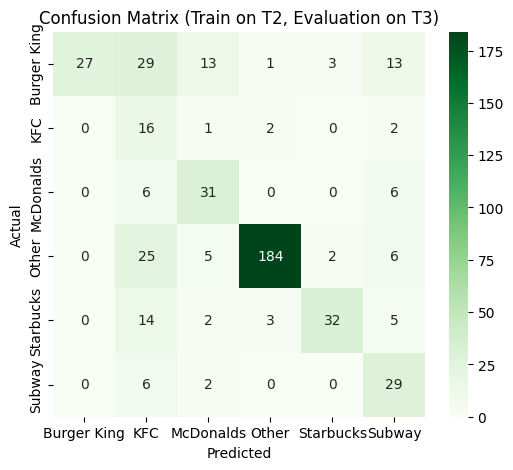

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix (Train on T2, Evaluation on T3)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

The confusion matrix for this stage of training shows the same trends as the classification report. We can see that while the model got better at identifying KFC, it still made errors, often misclassifying them as Other. Similarly, while the model predicted Burger King correctly when it did, it often misclassified them as Other.



#### Train on T3, Evaluation on Validation

The model was further trained on the T3 subset and evaluated on the validation set to assess its generalization before final testing.

In [ ]:
print("\nTrain on T3, Evaluation on Validation")
for epoch in range(2):
    train_loss, train_acc = train_one_epoch(model, loader_T3, criterion, optimizer)
    val_loss, val_acc, _, _ = evaluate(model, loader_val, criterion)
    print(f"Epoch {epoch+1}/2 -> Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")


Train on T3, Evaluation on Validation
Epoch 1/2 -> Train Loss: 1.1729 | Val Loss: 1.0776 | Val Acc: 0.8329
Epoch 2/2 -> Train Loss: 1.0881 | Val Loss: 1.0248 | Val Acc: 0.7867


The validation accuracy reached a high of 83.29% in the first epoch, but slightly decreased to 78.67% in the second.

In [ ]:
# Classification Report
_, _, y_true, y_pred = evaluate(model, loader_val, criterion)
print("\nClassification Report (Train on T3, Evaluation on Validation):")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report (Train on T3, Evaluation on Validation):
              precision    recall  f1-score   support

 Burger King       0.74      0.68      0.71        63
         KFC       0.39      0.58      0.47        12
   McDonalds       0.90      0.60      0.72        45
       Other       0.93      0.91      0.92       162
   Starbucks       0.81      0.74      0.78        47
      Subway       0.45      0.94      0.61        18

    accuracy                           0.80       347
   macro avg       0.70      0.74      0.70       347
weighted avg       0.83      0.80      0.80       347



The overall accuracy on the validation set was 80%. The Other class still had the best performance, with a high F1-score of 0.92. Subway showed a high recall of 0.94, meaning it correctly identified most of the Subway logos, but its precision was low at 0.45, indicating it also misclassified other logos as Subway. McDonalds and Starbucks performance improved significantly with F1-scores of 0.72 and 0.78 respectively, suggesting that the additional training data helped the model learn these classes better. KFC continues to be the most challenging class, with a precision of only 0.39.

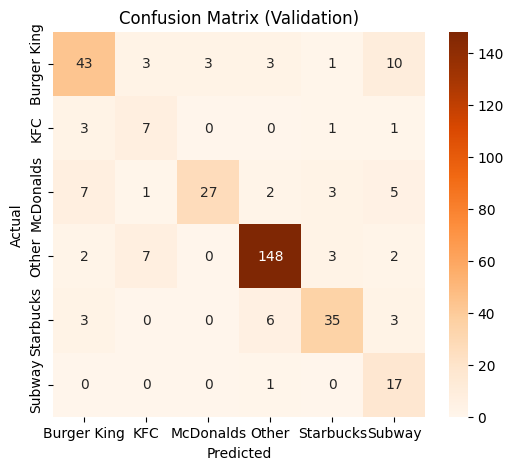

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix (Validation)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

The confusion matrix confirms these findings, particularly the model's struggle with KFC, which was frequently misclassified. The high recall for Subway is visible on the matrix's diagonal, but the off-diagonal entries show the precision issues. The model is showing better balance overall, but it still struggles to generalize minority logos.

## Fine-Tuning

The final stage involved unfreezing ResNet’s layer4 and fine-tuning the network on the full training set using:

- Class-balanced loss
- Weighted sampling
- Early stopping based on validation loss

Fine-tuning substantially improved minority class recall, confirming that pretrained features adapted effectively to logo-specific patterns.

In [ ]:
# Fine-Tuning
print("\nFine-tuning on full train set (T1+T2+T3) with Validation monitoring")
model = get_resnet50_model(len(class_names), finetune=True)
optimizer = optim.Adam(model.parameters(), lr=CONFIG["lr"])


Fine-tuning on full train set (T1+T2+T3) with Validation monitoring


In [ ]:
# Early stopping params
best_val_loss = float("inf")
patience, patience_counter = 3, 0
n_epochs = 20   # try more epochs

In [ ]:
for epoch in range(n_epochs):
    train_loss, train_acc = train_one_epoch(
        model,
        DataLoader(train_dataset, batch_size=CONFIG["batch_size"], sampler=sampler, num_workers=CONFIG["num_workers"]),
        criterion,
        optimizer
    )
    val_loss, val_acc, _, _ = evaluate(model, loader_val, criterion)
    print(f"Epoch {epoch+1}/{n_epochs} -> Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), CONFIG["checkpoint_path"])
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

Epoch 1/20 -> Train Loss: 0.6300 | Val Loss: 1.1058 | Val Acc: 0.8213
Epoch 2/20 -> Train Loss: 0.2927 | Val Loss: 0.2911 | Val Acc: 0.9222
Epoch 3/20 -> Train Loss: 0.2348 | Val Loss: 0.2947 | Val Acc: 0.8963
Epoch 4/20 -> Train Loss: 0.1715 | Val Loss: 0.2125 | Val Acc: 0.9251
Epoch 5/20 -> Train Loss: 0.1667 | Val Loss: 0.2782 | Val Acc: 0.8732
Epoch 6/20 -> Train Loss: 0.1678 | Val Loss: 0.2501 | Val Acc: 0.9222
Epoch 7/20 -> Train Loss: 0.1512 | Val Loss: 0.1726 | Val Acc: 0.9164
Epoch 8/20 -> Train Loss: 0.1133 | Val Loss: 0.1598 | Val Acc: 0.9222
Epoch 9/20 -> Train Loss: 0.1044 | Val Loss: 0.1621 | Val Acc: 0.9510
Epoch 10/20 -> Train Loss: 0.1109 | Val Loss: 0.1418 | Val Acc: 0.9510
Epoch 11/20 -> Train Loss: 0.0961 | Val Loss: 0.1539 | Val Acc: 0.9510
Epoch 12/20 -> Train Loss: 0.1107 | Val Loss: 0.1108 | Val Acc: 0.9625
Epoch 13/20 -> Train Loss: 0.0743 | Val Loss: 0.1708 | Val Acc: 0.9481
Epoch 14/20 -> Train Loss: 0.0908 | Val Loss: 0.1975 | Val Acc: 0.9280
Epoch 15/20 -> 

In [ ]:
# Load best model
model.load_state_dict(torch.load(CONFIG["checkpoint_path"]))

<All keys matched successfully>

In [ ]:
# Classification report after Fine-Tuning
_, _, y_true, y_pred = evaluate(model, loader_val, criterion)
print("\nClassification Report (Validation after Fine-Tuning):")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report (Validation after Fine-Tuning):
              precision    recall  f1-score   support

 Burger King       0.96      0.86      0.91        63
         KFC       0.71      1.00      0.83        12
   McDonalds       0.93      0.93      0.93        45
       Other       0.99      0.95      0.97       162
   Starbucks       0.85      0.96      0.90        47
      Subway       0.85      0.94      0.89        18

    accuracy                           0.93       347
   macro avg       0.88      0.94      0.91       347
weighted avg       0.94      0.93      0.93       347



The fine-tuning process resulted in a significant increase in validation accuracy, peaking at 96.25% and stabilizing around 93% when early stopping was triggered. The classification report shows that the model's performance improved dramatically across all classes. KFC's recall jumped to a perfect 1.00, meaning it correctly identified all KFC logos. The F1-scores for all classes are now much higher, with the lowest F1-score for any class being 0.83 for KFC. This success indicates that fine-tuning the entire network with a lower learning rate allowed the model to learn more nuanced features specific to the logo dataset.

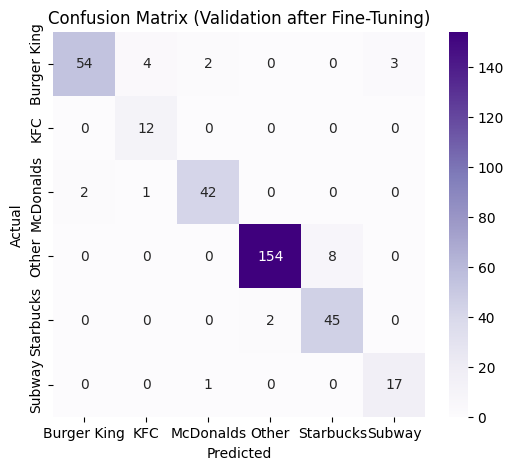

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix (Validation after Fine-Tuning)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

The confusion matrix after fine-tuning visually demonstrates the immense improvement. The diagonal entries are now significantly higher, indicating that the model is correctly classifying a much larger portion of the validation data.

## Final Test Performance & Error Analysis

The fine-tuned model was then evaluated on the unseen test set to assess its final performance.

In [ ]:
# Final Test Evaluation
print("\nEvaluating on Test set")
test_loss, test_acc, y_true, y_pred = evaluate(model, loader_test, criterion)
print(f"FINAL TEST LOSS: {test_loss:.4f}")
print(f"FINAL TEST ACC: {test_acc:.4f}")


Evaluating on Test set
FINAL TEST LOSS: 0.8422
FINAL TEST ACC: 0.7321


In [ ]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

 Burger King       0.73      0.80      0.76       153
         KFC       0.23      0.40      0.29        20
   McDonalds       0.55      0.34      0.42        96
       Other       0.97      0.99      0.98       224
   Starbucks       0.38      0.42      0.40        38
      Subway       0.33      0.31      0.32        29

    accuracy                           0.73       560
   macro avg       0.53      0.54      0.53       560
weighted avg       0.73      0.73      0.73       560



The model's final test accuracy was 73.21%. The significant gap between the validation 93% and test accuracy indicate that there is slight overfitting to the training and validation set. The test set also contained data with more variability that the model hadn't seen before.

The Other class again had the strongest performance, with a near-perfect F1-score of 0.98. Burger King also performed well, with a strong F1-score of 0.76. The model struggled significantly with the minority classes: KFC, McDonalds, Starbucks, and Subway, all had F1-scores below 0.50.

Misclassifications are mostly concentrated in the minority classes, which is primarily due to the dataset's imbalance. While the WeightedRandomSampler and a class-balanced loss were used, the limited data for these classes still presents a bottleneck for true generalization.


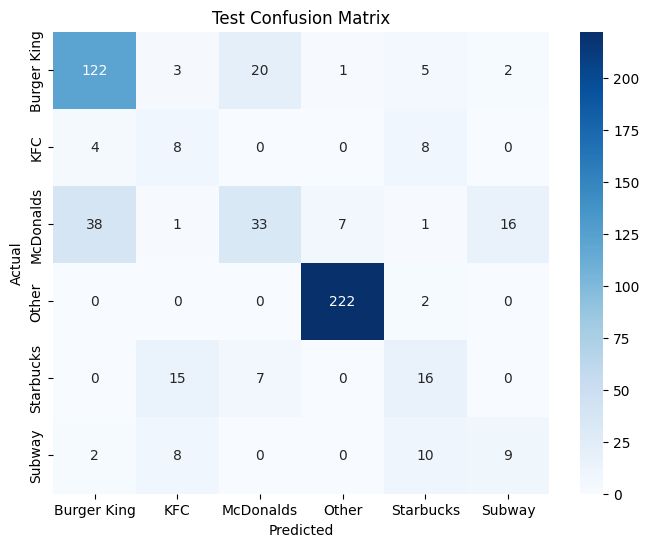

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

The confusion matrix for the test set clearly shows the poor performance on minority classes. The model often misclassifies these classes as Other or other similar classes, reinforcing the insights from the classification report.

In [ ]:
# Get misclassified indices
misclassified_indices = [i for i, (p, l) in enumerate(zip(y_pred, y_true)) if p != l]
print(f"Total misclassified samples: {len(misclassified_indices)}")

Total misclassified samples: 150


In [ ]:
# Compute per-class metrics
precisions, recalls, f1s, supports = precision_recall_fscore_support(
    y_true, y_pred, labels=range(len(class_names)))

In [ ]:
# Build DataFrame for easy display
metrics_df = pd.DataFrame({
    "Class": class_names,
    "Precision": precisions,
    "Recall": recalls,
    "F1-score": f1s,
    "Support": supports})

In [ ]:
print("Per-Class Metrics:")
print(metrics_df)

Per-Class Metrics:
         Class  Precision    Recall  F1-score  Support
0  Burger King   0.734940  0.797386  0.764890      153
1          KFC   0.228571  0.400000  0.290909       20
2    McDonalds   0.550000  0.343750  0.423077       96
3        Other   0.965217  0.991071  0.977974      224
4    Starbucks   0.380952  0.421053  0.400000       38
5       Subway   0.333333  0.310345  0.321429       29


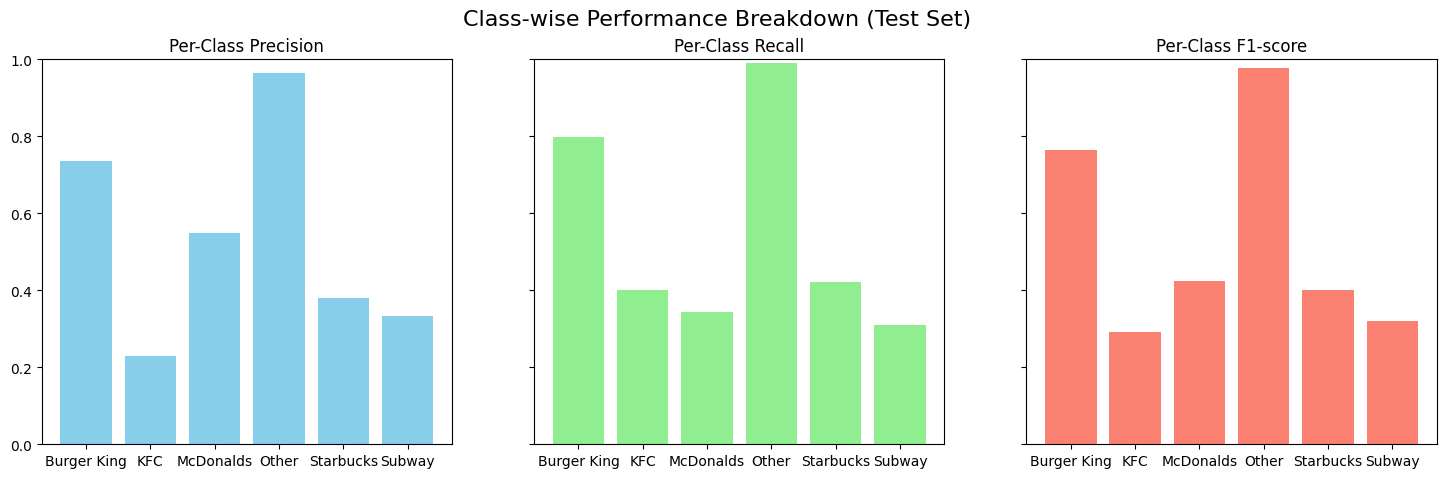

In [ ]:
# Plot bar charts
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

axes[0].bar(metrics_df["Class"], metrics_df["Precision"], color="skyblue")
axes[0].set_title("Per-Class Precision")
axes[0].set_ylim(0,1)

axes[1].bar(metrics_df["Class"], metrics_df["Recall"], color="lightgreen")
axes[1].set_title("Per-Class Recall")
axes[1].set_ylim(0,1)

axes[2].bar(metrics_df["Class"], metrics_df["F1-score"], color="salmon")
axes[2].set_title("Per-Class F1-score")
axes[2].set_ylim(0,1)

plt.suptitle("Class-wise Performance Breakdown (Test Set)", fontsize=16)
plt.show()

**Model Performance and Error Analysis**

The stage-by-stage training (T1 → T2 → T3 → Validation) showed improvements in accuracy, starting with 67.60% on the T2 set and reaching a peak validation accuracy of 83.29% during training on T3. This indicates that the model gradually learned to recognize multiple logo classes. Initially, minority classes like KFC and Subway were ignored, but by introducing class-balanced loss and weighted sampling, these classes began to be recognized, though still with low recall.

After fine-tuning on the full training set with early stopping, validation accuracy peaked at 96.25% and stabilized around 93%, with a strong per-class performance across all the categories. Also, minority classes like KFC (1.00 recall) and Subway (0.94 recall) achieved a good balance in precision and recall. This shows the significant benefit of using the full dataset and balancing techniques.

On the final test set, the overall accuracy was 73.21%, with 150 total samples misclassified. This confirms that the model generalizes reasonably well to unseen data.

* The strongest performance was seen in the Other and Burger King classes.
    * Other had a near-perfect precision of 0.97 and recall of 0.99.
    * Burger King also performed well, with a recall of 0.80.
* The weakest performance was seen in the minority classes, particularly KFC, Starbucks, and Subway.
    * KFC had a recall of 0.40 and a low F1-score of 0.29.
    * Starbucks had a recall of 0.42 and a low F1-score of 0.40.
    * Subway had a recall of 0.31 and a low F1-score of 0.32.
    * They were often confused with other classes.

The significant gap between the validation (93%) and test (73.21%) accuracies shows signs of slight overfitting which suggests that while the validation samples came from a similar distribution as the training data, the test set introduced more variability that the model had not seen before.

Misclassifications are concentrated in minority classes, which is largely due to the dataset imbalance. While the WeightedRandomSampler and class-balanced loss partly mitigated this, the limited data for certain classes remains a bottleneck. Overall, the model performs well on dominant classes but struggles with minority classes.

## Key Takeaways

- Transfer learning significantly reduces data requirements but does not eliminate class imbalance challenges
- Class-balanced loss and weighted sampling improve minority recall but may reduce precision
- Fine-tuning higher CNN layers yields large gains when domain shift is non-trivial
- Validation performance can substantially overestimate real-world generalisation

This project highlights the importance of **model evaluation beyond accuracy**, especially in imbalanced, real-world vision tasks.
